# Imports

In [4]:
from concurrent.futures import ThreadPoolExecutor
import os
from pathlib import Path
from typing import Optional
from src.data.paths import project_dir
from src.data.analysis import Circle, get_mean_std, get_timestamp, create_circular_mask

import numpy as np
import numpy.typing as npt
from scipy import ndimage
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from matplotlib.patches import Circle as CirclePatch

In [5]:
from typing import List
def read_df(path : Path , det_names : List[str], analysis_radius : float = 300) -> pd.DataFrame:
    df = pd.DataFrame()
    df["det_id"] = det_names
    df.det_id = df.det_id.astype('uint8')
    df["raw_data"] = df.det_id.apply(lambda id: np.load(path / f"{id}" / "raw.npy"))
    df["timestamp"] = df.det_id.apply(lambda id: get_timestamp(path / f"{id}" / "metadata.txt"))
    df["det_circle"] = df.det_id.apply(lambda x: Circle.from_json(path / f"{x}lv" / "det-circle.json"))
    df["det_angle"] = df.det_id.apply(lambda id: np.load(path / f"{id}lv" / "angle.npy"))
    df["raw_mean_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[0], axis=1)
    df["raw_std_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[1], axis=1)

    df['analysis_circle'] = df.det_circle.apply(lambda c: Circle(c.x, c.y, analysis_radius))
    df["raw_mean"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[0], axis=1)
    df["raw_std"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[1], axis=1)
    return df

# Data reading

In [6]:
pre_irr_bg = project_dir / "data" / "interim" / "foils" / "2022_11_23_background"
pre_irr_bg_ids = sorted((entry.name for entry in pre_irr_bg.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_pre_bg = read_df(pre_irr_bg, pre_irr_bg_ids)
df_pre_bg["label"] = "pre_irr_bg"
# df_pre_bg.head()

In [7]:
data_co60 = project_dir / "data" / "interim" / "foils" / "2022_11_23_Co60"
data_co60_ids = sorted((entry.name for entry in data_co60.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_Co60 = read_df(data_co60, data_co60_ids)
df_Co60["label"] = "Co60"
# df_Co60.head()

In [8]:
ff_image_path = project_dir / "data" / "interim" / "foils" / "2022_08_22_flat_field" / "FF_2sLED_U340" / "FF_1" / "raw.npy"
ff_data = np.load(ff_image_path)

In [9]:
data_sobp = project_dir / "data" / "interim" / "foils" / "2022_11_18_sobp"
data_sobp_ids = sorted((entry.name for entry in data_sobp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_sobp = read_df(data_sobp, data_sobp_ids)
df_sobp["label"] = "SOBP"
# df_Co60.head()

In [10]:
data_bp = project_dir / "data" / "interim" / "foils" / "2022_11_17_bp"
data_bp_ids = sorted((entry.name for entry in data_bp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_bp = read_df(data_bp, data_bp_ids)
df_bp["label"] = "BP"
# df_Co60.head()

In [11]:
# apply correction for sensor stability as function of time
x = df_pre_bg.timestamp.apply(lambda x: (x - df_pre_bg.timestamp.min()).total_seconds()).values
y = df_pre_bg.raw_mean_center.values
a,b = np.polyfit(x, y, 1)
print(f"a = {a}, b = {b}")

df_pre_bg["raw_data_stabilised"] = df_pre_bg.apply(lambda x: x.raw_data - a * (x.timestamp - df_pre_bg.timestamp.min()).total_seconds() , axis=1)
df_Co60["raw_data_stabilised"] = df_Co60.apply(lambda x: x.raw_data , axis=1)
df_sobp["raw_data_stabilised"] = df_sobp.apply(lambda x: x.raw_data - a * (x.timestamp - df_sobp.timestamp.min()).total_seconds() , axis=1)
df_bp["raw_data_stabilised"] = df_bp.apply(lambda x: x.raw_data - a * (x.timestamp - df_bp.timestamp.min()).total_seconds() , axis=1)

df_pre_bg["raw_mean_stabilized"] = df_pre_bg.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_Co60["raw_mean_stabilized"] = df_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_sobp["raw_mean_stabilized"] = df_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_bp["raw_mean_stabilized"] = df_bp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)

a = 0.001687053830354033, b = 1039.8119645231088


# Data inspection

In [12]:

def singal_df(df_data : pd.DataFrame, df_bg : pd.DataFrame, ff_array : Optional[npt.NDArray] = None, analysis_radius : float = 300) -> pd.DataFrame:
    df_signal = df_data.copy()
    df_signal.set_index("det_id", inplace=True)

    # remove background
    df_bg.set_index("det_id", inplace=True)
    df_signal["bg_sub"] = df_signal.raw_data - df_bg.raw_data
    df_signal["bg_sub_stabilized"] = df_signal.raw_data_stabilised - df_bg.raw_data_stabilised
    df_bg.reset_index(inplace=True)

    # apply FF
    df_signal["sensor_corr"] = df_signal.bg_sub_stabilized
    if ff_array is not None:
        big_circle = Circle(x=ff_array.shape[1]/2, y=ff_array.shape[0]/2, r=ff_array.shape[1]/2-10)
        mask = create_circular_mask(img=ff_data, circle_px=big_circle)
        gain =  ff_array / np.mean(ff_array[mask])
        df_signal["sensor_corr"] = df_signal.bg_sub_stabilized.apply(lambda x: x / gain)
        
    # move to center, faster version using multiple threads
    no_of_cpus = os.cpu_count()
    if no_of_cpus is None:
        no_of_cpus = 1
    def shift(data: npt.NDArray, x : float, y : float) -> npt.NDArray:
        return ndimage.shift(data, (data.shape[1]/2-y,data.shape[0]/2-x), cval=np.nan, prefilter=False)
    def apply_shift(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: shift(x.sensor_corr, x.det_circle.x, x.det_circle.y), axis=1)    
    with ThreadPoolExecutor() as executor:
        chunks_of_shifted_df = executor.map(apply_shift, np.array_split(df_signal, no_of_cpus))
    df_signal["centered"] = pd.concat(chunks_of_shifted_df)

    df_signal["analysis_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, analysis_radius)), axis=1)
    df_signal["detector_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, x.det_circle.r)), axis=1)
    
    # rotate
    def rotate(data: npt.NDArray, angle_deg : float) -> npt.NDArray:
        return ndimage.rotate(data, -angle_deg, cval=np.nan, reshape=False, prefilter=False)
    def apply_rotate(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: rotate(x.centered, x.det_angle), axis=1)
    with ThreadPoolExecutor() as executor:
        chunks_of_rotated_df = executor.map(apply_rotate, np.array_split(df_signal, no_of_cpus))
    df_signal["rotated"] = pd.concat(chunks_of_rotated_df)
    
    return df_signal

In [13]:
df_signal_ref = singal_df(df_Co60, df_bg=df_pre_bg, ff_array=ff_data)
#signal_Co60.head()

In [14]:
df_signal_sobp = singal_df(df_sobp, df_bg=df_pre_bg, ff_array=ff_data)
#signal_Co60.head()

In [15]:
df_signal_bp = singal_df(df_bp, df_bg=df_pre_bg, ff_array=ff_data)

In [16]:
df_signal_bp["dose_Gy"] = 60. * df_signal_bp.rotated / df_signal_ref.rotated
df_signal_bp["dose_Gy_mean"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_bp["dose_Gy_std"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)

In [17]:
df_signal_sobp["dose_Gy"] = 60. * df_signal_sobp.rotated / df_signal_ref.rotated
df_signal_sobp["dose_Gy_mean"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_sobp["dose_Gy_std"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)

# Data inspection

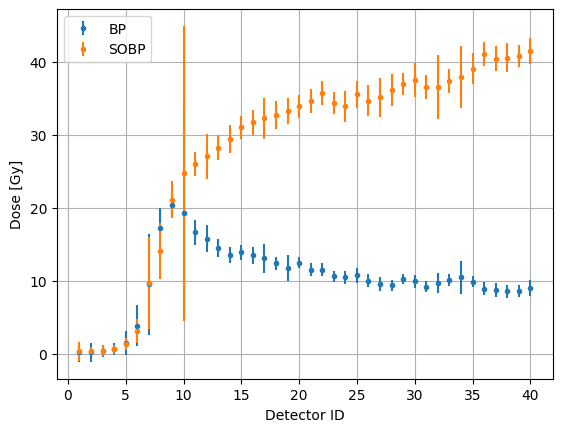

In [18]:
fig, ax = plt.subplots()
ax.errorbar(df_signal_bp.reset_index().det_id, df_signal_bp.dose_Gy_mean, yerr=df_signal_bp.dose_Gy_std, marker=".", linestyle="", label="BP")
ax.errorbar(df_signal_sobp.reset_index().det_id, df_signal_sobp.dose_Gy_mean, yerr=df_signal_sobp.dose_Gy_std, marker=".", linestyle="", label="SOBP")
ax.grid()
ax.set_xlabel("Detector ID")
ax.set_ylabel("Dose [Gy]")
ax.legend();

In [19]:
df_signal_bp.dose_Gy_mean.iloc[-4:] / 12

det_id
37    0.724342
38    0.713670
39    0.713721
40    0.751982
Name: dose_Gy_mean, dtype: float64

In [20]:
df_signal_sobp.dose_Gy_mean.iloc[-4:] / 60

det_id
37    0.673277
38    0.675858
39    0.679751
40    0.690393
Name: dose_Gy_mean, dtype: float64

Text(0, 0.5, 'SOBP / BP')

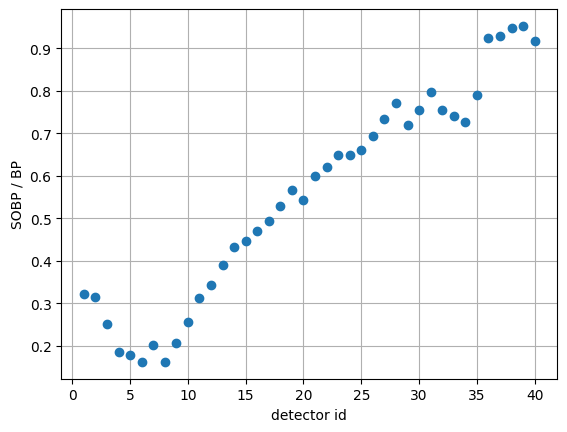

In [21]:
fig, ax = plt.subplots()
ax.plot(df_signal_bp.reset_index().det_id, (df_signal_sobp.dose_Gy_mean / 60) / (df_signal_bp.dose_Gy_mean / 12), label="efficiency", marker="o", linestyle="None")
ax.grid()
ax.set_xlabel("detector id")
ax.set_ylabel("SOBP / BP")

# Positions

In [45]:
positions = """
0,28
0,85
1,43
2,00
2,53
4,18
6,97
9,73
11,37
11,93
12,47
13,00
13,55
14,09
14,62
15,17
15,71
16,25
16,81
17,35
17,90
18,46
19,01
19,55
20,12
20,67
21,24
21,81
22,38
22,96
23,51
24,06
24,59
25,16
25,72
26,28
26,84
27,38
27,92
28,46
29,00
29,56
30,11
""".replace(",", ".").split()
positions.pop(5)
positions.pop(5)
positions.pop(5)

'9.73'

In [46]:
import numpy as np
pos_mm = np.array(positions, dtype=float)
pos_mm.shape 

(40,)

In [47]:
pos_mm

array([ 0.28,  0.85,  1.43,  2.  ,  2.53, 11.37, 11.93, 12.47, 13.  ,
       13.55, 14.09, 14.62, 15.17, 15.71, 16.25, 16.81, 17.35, 17.9 ,
       18.46, 19.01, 19.55, 20.12, 20.67, 21.24, 21.81, 22.38, 22.96,
       23.51, 24.06, 24.59, 25.16, 25.72, 26.28, 26.84, 27.38, 27.92,
       28.46, 29.  , 29.56, 30.11])

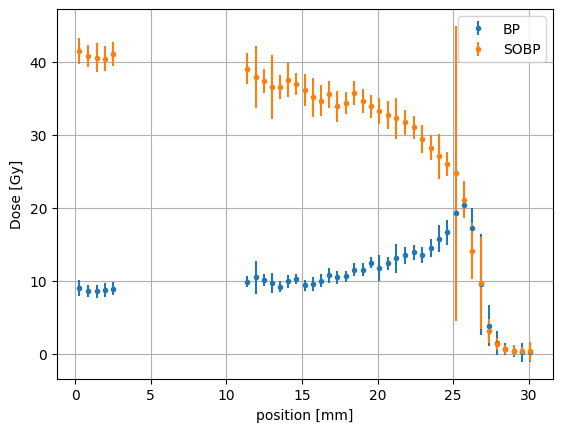

In [48]:
fig, ax = plt.subplots()
ax.errorbar(pos_mm[::-1], df_signal_bp.dose_Gy_mean, yerr=df_signal_bp.dose_Gy_std, marker=".", linestyle="", label="BP")
ax.errorbar(pos_mm[::-1], df_signal_sobp.dose_Gy_mean, yerr=df_signal_sobp.dose_Gy_std, marker=".", linestyle="", label="SOBP")
ax.grid()
ax.set_xlabel("position [mm]")
ax.set_ylabel("Dose [Gy]")
ax.legend();